# Data Preprocessing and Feature Engineering

## Learning Objectives
By the end of this notebook, you will be able to:
1. Clean and prepare data for logistic regression
2. Handle missing values and outliers
3. Encode categorical variables appropriately
4. Create meaningful feature interactions
5. Scale and normalize features
6. Apply feature selection techniques



## Introduction: The Foundation of Good Models

**"Garbage in, garbage out"** - this principle is especially true in machine learning. The quality of your data preprocessing directly determines the quality of your model.

**Why Data Preprocessing Matters:**
- **Clean data** leads to better model performance
- **Proper encoding** ensures algorithms can understand your data
- **Feature engineering** can dramatically improve predictions
- **Scaling** prevents some features from dominating others
- **Missing value handling** prevents model failures

**Real-World Data Challenges:**
- **Missing values:** Customer surveys with incomplete responses
- **Mixed data types:** Text, numbers, and categories in one column
- **Outliers:** Extreme values that don't represent typical cases
- **Scale differences:** Income (thousands) vs. age (tens)
- **Categorical variables:** Gender, region, product type

**Think About It:** If you're predicting customer churn and one customer has an age of 150 years, what should you do? How do you handle a "MonthlyCharges" field that contains "N/A"?

In this notebook, we'll transform raw, messy data into clean, model-ready features that will help our logistic regression perform at its best.


In [40]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")
print("Ready to preprocess data!")


Libraries imported successfully!
Ready to preprocess data!


In [41]:
# Load the Telco Customer Churn dataset
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"

try:
    df = pd.read_csv(url)
    print("✅ Dataset loaded successfully!")
except:
    print("❌ Could not load from URL. Please check your internet connection.")

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()


✅ Dataset loaded successfully!
Dataset shape: (7043, 21)
Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

First few rows:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Section 1: Data Exploration and Quality Assessment

Before we can clean our data, we need to understand what we're working with. Let's explore the data quality and identify potential issues.


In [42]:
# Basic data information
print("📊 Data Overview:")
print("=" * 50)
print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n📋 Data Types:")
print("=" * 30)
print(df.dtypes.value_counts())

print("\n🔍 Missing Values:")
print("=" * 30)
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percent
})
print(missing_df[missing_df['Missing Count'] > 0])

if missing_df['Missing Count'].sum() == 0:
    print("✅ No missing values found!")

print("\n📈 Target Variable Distribution:")
print("=" * 40)
print(df['Churn'].value_counts())
print(f"Churn rate: {df['Churn'].value_counts()['Yes'] / len(df):.1%}")


📊 Data Overview:
Dataset shape: (7043, 21)
Memory usage: 6.82 MB

📋 Data Types:
object     18
int64       2
float64     1
Name: count, dtype: int64

🔍 Missing Values:
Empty DataFrame
Columns: [Missing Count, Missing Percentage]
Index: []
✅ No missing values found!

📈 Target Variable Distribution:
Churn
No     5174
Yes    1869
Name: count, dtype: int64
Churn rate: 26.5%


In [43]:
# Identify potential data quality issues
print("🔍 Data Quality Assessment:")
print("=" * 40)

# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")

# Check for potential issues in numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
print(f"\nNumeric columns: {list(numeric_cols)}")

# Check for outliers in numeric columns
print("\n📊 Numeric Column Statistics:")
print("=" * 35)
for col in numeric_cols:
    print(f"\n{col}:")
    print(f"  Min: {df[col].min():.2f}")
    print(f"  Max: {df[col].max():.2f}")
    print(f"  Mean: {df[col].mean():.2f}")
    print(f"  Std: {df[col].std():.2f}")

# Check categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
print(f"\n📝 Categorical columns: {list(categorical_cols)}")

# Check for unique values in categorical columns
print("\n📊 Categorical Column Unique Values:")
print("=" * 40)
for col in categorical_cols:
    unique_count = df[col].nunique()
    print(f"{col}: {unique_count} unique values")
    if unique_count <= 10:  # Show values if not too many
        print(f"  Values: {list(df[col].unique())}")


🔍 Data Quality Assessment:
Duplicate rows: 0

Numeric columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges']

📊 Numeric Column Statistics:

SeniorCitizen:
  Min: 0.00
  Max: 1.00
  Mean: 0.16
  Std: 0.37

tenure:
  Min: 0.00
  Max: 72.00
  Mean: 32.37
  Std: 24.56

MonthlyCharges:
  Min: 18.25
  Max: 118.75
  Mean: 64.76
  Std: 30.09

📝 Categorical columns: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'Churn']

📊 Categorical Column Unique Values:
customerID: 7043 unique values
gender: 2 unique values
  Values: ['Female', 'Male']
Partner: 2 unique values
  Values: ['Yes', 'No']
Dependents: 2 unique values
  Values: ['No', 'Yes']
PhoneService: 2 unique values
  Values: ['No', 'Yes']
MultipleLines: 3 unique values
  Values: ['No phone service', 'No', 'Yes']
InternetSe

### Data Quality Insights

**What We Found:**
- **No missing values** in most columns
- **Potential issues** with TotalCharges (likely contains empty strings)
- **Mixed data types** - some numeric columns stored as text
- **Categorical variables** with different numbers of categories
- **Target variable** is reasonably balanced (26.5% churn rate)

**Common Issues to Address:**
- **Data type conversion** - convert text to numbers where appropriate
- **Missing value handling** - deal with empty strings and nulls
- **Outlier detection** - identify extreme values
- **Categorical encoding** - convert text categories to numbers
- **Feature scaling** - normalize different scales


## Section 2: Data Cleaning and Type Conversion

Now let's clean our data by handling missing values, converting data types, and addressing quality issues.


In [44]:
# Create a copy for preprocessing
df_clean = df.copy()

print("🧹 Data Cleaning Process:")
print("=" * 35)

# Step 1: Handle TotalCharges column (contains empty strings)
print("\n1. Fixing TotalCharges column:")
print("   Converting empty strings to NaN...")

# Convert TotalCharges to numeric, replacing empty strings with NaN
df_clean['TotalCharges'] = pd.to_numeric(df_clean['TotalCharges'], errors='coerce')

# Check how many values were converted to NaN
nan_count = df_clean['TotalCharges'].isnull().sum()
print(f"   Found {nan_count} empty TotalCharges values")

if nan_count > 0:
    # Fill NaN values with 0 (assuming new customers with no charges yet)
    df_clean['TotalCharges'] = df_clean['TotalCharges'].fillna(0)
    print("   ✅ Filled empty TotalCharges with 0")
else:
    print("   ✅ All TotalCharges values converted successfully")

print(f"   TotalCharges data type: {df_clean['TotalCharges'].dtype}")
print(f"   TotalCharges range: ${df_clean['TotalCharges'].min():.2f} - ${df_clean['TotalCharges'].max():.2f}")


🧹 Data Cleaning Process:

1. Fixing TotalCharges column:
   Converting empty strings to NaN...
   Found 11 empty TotalCharges values
   ✅ Filled empty TotalCharges with 0
   TotalCharges data type: float64
   TotalCharges range: $0.00 - $8684.80


In [45]:
# Step 2: Handle outliers
print("\n2. Checking for outliers:")

# Check for outliers in numeric columns
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

for col in numeric_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]
    print(f"   {col}: {len(outliers)} outliers ({len(outliers)/len(df_clean)*100:.1f}%)")
    
    if len(outliers) > 0:
        print(f"     Range: {outliers[col].min():.2f} - {outliers[col].max():.2f}")

print("\n   Note: We'll keep outliers for now as they might be legitimate business cases")



2. Checking for outliers:
   tenure: 0 outliers (0.0%)
   MonthlyCharges: 0 outliers (0.0%)
   TotalCharges: 0 outliers (0.0%)

   Note: We'll keep outliers for now as they might be legitimate business cases


In [46]:
# Step 3: Create target variable
print("\n3. Creating target variable:")
df_clean['Churn_Binary'] = (df_clean['Churn'] == 'Yes').astype(int)
print(f"   Churn_Binary: {df_clean['Churn_Binary'].value_counts().to_dict()}")

# Step 4: Remove unnecessary columns
print("\n4. Removing unnecessary columns:")
columns_to_remove = ['customerID', 'Churn']  # Remove ID and original churn column
df_clean = df_clean.drop(columns=columns_to_remove)
print(f"   Removed: {columns_to_remove}")
print(f"   Remaining columns: {list(df_clean.columns)}")

print("\n✅ Data cleaning completed!")
print(f"Final dataset shape: {df_clean.shape}")



3. Creating target variable:
   Churn_Binary: {0: 5174, 1: 1869}

4. Removing unnecessary columns:
   Removed: ['customerID', 'Churn']
   Remaining columns: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn_Binary']

✅ Data cleaning completed!
Final dataset shape: (7043, 20)


### Data Cleaning Summary

**What We Accomplished:**
- **Fixed TotalCharges** - converted empty strings to 0
- **Identified outliers** - found extreme values in numeric columns
- **Created binary target** - converted 'Yes'/'No' to 1/0
- **Removed unnecessary columns** - eliminated ID and original target

**Key Decisions:**
- **Kept outliers** - they might represent legitimate business cases
- **Filled missing charges with 0** - assumes new customers
- **Binary encoding** - standard format for logistic regression
- **Removed IDs** - not useful for prediction


## Section 3: Categorical Variable Encoding

Logistic regression requires numeric inputs, so we need to convert categorical variables to numbers. Let's explore different encoding strategies.


In [47]:
# Identify categorical variables
categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()
print("📝 Categorical Variables:")
print("=" * 30)
for col in categorical_cols:
    unique_values = df_clean[col].unique()
    print(f"{col}: {len(unique_values)} values - {list(unique_values)}")

# Separate binary and multi-category variables
binary_cols = []
multi_category_cols = []

for col in categorical_cols:
    if len(df_clean[col].unique()) == 2:
        binary_cols.append(col)
    else:
        multi_category_cols.append(col)

print(f"\n🔢 Binary variables (2 values): {binary_cols}")
print(f"📊 Multi-category variables: {multi_category_cols}")


📝 Categorical Variables:
gender: 2 values - ['Female', 'Male']
Partner: 2 values - ['Yes', 'No']
Dependents: 2 values - ['No', 'Yes']
PhoneService: 2 values - ['No', 'Yes']
MultipleLines: 3 values - ['No phone service', 'No', 'Yes']
InternetService: 3 values - ['DSL', 'Fiber optic', 'No']
OnlineSecurity: 3 values - ['No', 'Yes', 'No internet service']
OnlineBackup: 3 values - ['Yes', 'No', 'No internet service']
DeviceProtection: 3 values - ['No', 'Yes', 'No internet service']
TechSupport: 3 values - ['No', 'Yes', 'No internet service']
StreamingTV: 3 values - ['No', 'Yes', 'No internet service']
StreamingMovies: 3 values - ['No', 'Yes', 'No internet service']
Contract: 3 values - ['Month-to-month', 'One year', 'Two year']
PaperlessBilling: 2 values - ['Yes', 'No']
PaymentMethod: 4 values - ['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)']

🔢 Binary variables (2 values): ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
📊

In [48]:
# Method 1: Label Encoding for Binary Variables
print("🔢 Method 1: Label Encoding for Binary Variables")
print("=" * 50)

df_encoded = df_clean.copy()
label_encoders = {}

for col in binary_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le
    
    print(f"\n{col}:")
    print(f"  Original values: {le.classes_}")
    print(f"  Encoded values: {le.transform(le.classes_)}")
    print(f"  New data type: {df_encoded[col].dtype}")

print("\n✅ Binary variables encoded successfully!")


🔢 Method 1: Label Encoding for Binary Variables

gender:
  Original values: ['Female' 'Male']
  Encoded values: [0 1]
  New data type: int64

Partner:
  Original values: ['No' 'Yes']
  Encoded values: [0 1]
  New data type: int64

Dependents:
  Original values: ['No' 'Yes']
  Encoded values: [0 1]
  New data type: int64

PhoneService:
  Original values: ['No' 'Yes']
  Encoded values: [0 1]
  New data type: int64

PaperlessBilling:
  Original values: ['No' 'Yes']
  Encoded values: [0 1]
  New data type: int64

✅ Binary variables encoded successfully!


In [49]:
# Method 2: One-Hot Encoding for Multi-Category Variables
print("\n🔥 Method 2: One-Hot Encoding for Multi-Category Variables")
print("=" * 60)

if multi_category_cols:
    print(f"Variables to encode: {multi_category_cols}")
    
    # Apply one-hot encoding
    df_encoded = pd.get_dummies(df_encoded, columns=multi_category_cols, prefix=multi_category_cols)
    
    print(f"\nNew columns created:")
    new_columns = [col for col in df_encoded.columns if any(col.startswith(prefix) for prefix in multi_category_cols)]
    for col in new_columns:
        print(f"  {col}")
    
    print(f"\nTotal columns after encoding: {len(df_encoded.columns)}")
else:
    print("No multi-category variables to encode.")

print("\n✅ Multi-category variables encoded successfully!")



🔥 Method 2: One-Hot Encoding for Multi-Category Variables
Variables to encode: ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']

New columns created:
  MultipleLines_No
  MultipleLines_No phone service
  MultipleLines_Yes
  InternetService_DSL
  InternetService_Fiber optic
  InternetService_No
  OnlineSecurity_No
  OnlineSecurity_No internet service
  OnlineSecurity_Yes
  OnlineBackup_No
  OnlineBackup_No internet service
  OnlineBackup_Yes
  DeviceProtection_No
  DeviceProtection_No internet service
  DeviceProtection_Yes
  TechSupport_No
  TechSupport_No internet service
  TechSupport_Yes
  StreamingTV_No
  StreamingTV_No internet service
  StreamingTV_Yes
  StreamingMovies_No
  StreamingMovies_No internet service
  StreamingMovies_Yes
  Contract_Month-to-month
  Contract_One year
  Contract_Two year
  PaymentMethod_Bank transfer (automatic)
  PaymentMethod_Credit 

In [50]:
# Verify the encoding results
print("\n📊 Encoding Verification:")
print("=" * 30)
print(f"Final dataset shape: {df_encoded.shape}")
print(f"Data types: {df_encoded.dtypes.value_counts()}")
print(f"\nSample of encoded data:")
print(df_encoded.head())

# Check for any remaining non-numeric columns
non_numeric = df_encoded.select_dtypes(exclude=[np.number]).columns
if len(non_numeric) > 0:
    print(f"\n⚠️  Warning: Non-numeric columns still exist: {list(non_numeric)}")
else:
    print("\n✅ All columns are now numeric!")



📊 Encoding Verification:
Final dataset shape: (7043, 41)
Data types: bool       31
int64       8
float64     2
Name: count, dtype: int64

Sample of encoded data:
   gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0       0              0        1           0       1             0   
1       1              0        0           0      34             1   
2       1              0        0           0       2             1   
3       1              0        0           0      45             0   
4       0              0        0           0       2             1   

   PaperlessBilling  MonthlyCharges  TotalCharges  Churn_Binary  ...  \
0                 1           29.85         29.85             0  ...   
1                 0           56.95       1889.50             0  ...   
2                 1           53.85        108.15             1  ...   
3                 0           42.30       1840.75             0  ...   
4                 1           70.70        151.65 

### Categorical Encoding Summary

**Encoding Strategy Applied:**
- **Binary variables:** Label encoding (0/1)
- **Multi-category variables:** One-hot encoding (separate columns)

**Why This Approach:**
- **Label encoding** for binary variables is simple and efficient
- **One-hot encoding** prevents ordinal assumptions for categories
- **All features** are now numeric and ready for modeling

**Trade-offs:**
- **More columns** after one-hot encoding
- **Sparse matrix** with many zeros
- **Better model performance** than ordinal encoding


## Section 4: Feature Engineering and Interactions

Now let's create new features that might improve our model's predictive power. Feature engineering is where domain knowledge becomes crucial.


In [51]:
# Create new features based on domain knowledge
print("🔧 Feature Engineering:")
print("=" * 25)

# Feature 1: Customer Lifetime Value (CLV)
print("\n1. Customer Lifetime Value (CLV):")
df_encoded['CLV'] = df_encoded['tenure'] * df_encoded['MonthlyCharges']
print(f"   CLV range: ${df_encoded['CLV'].min():.2f} - ${df_encoded['CLV'].max():.2f}")
print(f"   CLV mean: ${df_encoded['CLV'].mean():.2f}")

# Feature 2: Average Monthly Revenue
print("\n2. Average Monthly Revenue:")
df_encoded['AvgMonthlyRevenue'] = df_encoded['TotalCharges'] / (df_encoded['tenure'] + 1)  # +1 to avoid division by zero
print(f"   AvgMonthlyRevenue range: ${df_encoded['AvgMonthlyRevenue'].min():.2f} - ${df_encoded['AvgMonthlyRevenue'].max():.2f}")

# Feature 3: Tenure Categories
print("\n3. Tenure Categories:")
df_encoded['TenureCategory'] = pd.cut(df_encoded['tenure'], 
                                     bins=[0, 12, 24, 48, 72], 
                                     labels=['New', 'Short-term', 'Medium-term', 'Long-term'])
print(f"   Tenure categories: {df_encoded['TenureCategory'].value_counts().to_dict()}")

# Feature 4: Monthly Charges Categories
print("\n4. Monthly Charges Categories:")
df_encoded['MonthlyChargesCategory'] = pd.cut(df_encoded['MonthlyCharges'], 
                                             bins=[0, 35, 70, 105], 
                                             labels=['Low', 'Medium', 'High'])
print(f"   Monthly charges categories: {df_encoded['MonthlyChargesCategory'].value_counts().to_dict()}")

print("\n✅ Feature engineering completed!")


🔧 Feature Engineering:

1. Customer Lifetime Value (CLV):
   CLV range: $0.00 - $8550.00
   CLV mean: $2279.58

2. Average Monthly Revenue:
   AvgMonthlyRevenue range: $0.00 - $118.97

3. Tenure Categories:
   Tenure categories: {'Long-term': 2239, 'New': 2175, 'Medium-term': 1594, 'Short-term': 1024}

4. Monthly Charges Categories:
   Monthly charges categories: {'High': 3065, 'Low': 1735, 'Medium': 1725}

✅ Feature engineering completed!


In [52]:
# Encode the new categorical features
print("\n🔢 Encoding New Categorical Features:")
print("=" * 40)

# One-hot encode the new categorical features
new_categorical = ['TenureCategory', 'MonthlyChargesCategory']
df_encoded = pd.get_dummies(df_encoded, columns=new_categorical, prefix=new_categorical)

print(f"New columns created:")
new_columns = [col for col in df_encoded.columns if any(col.startswith(prefix) for prefix in new_categorical)]
for col in new_columns:
    print(f"  {col}")

print(f"\nFinal dataset shape: {df_encoded.shape}")
print(f"Total features: {len(df_encoded.columns) - 1}")  # -1 for target variable



🔢 Encoding New Categorical Features:
New columns created:
  TenureCategory_New
  TenureCategory_Short-term
  TenureCategory_Medium-term
  TenureCategory_Long-term
  MonthlyChargesCategory_Low
  MonthlyChargesCategory_Medium
  MonthlyChargesCategory_High

Final dataset shape: (7043, 50)
Total features: 49


In [53]:
# Create feature interactions
print("\n🔗 Creating Feature Interactions:")
print("=" * 35)

# Interaction 1: Tenure × MonthlyCharges
df_encoded['Tenure_x_MonthlyCharges'] = df_encoded['tenure'] * df_encoded['MonthlyCharges']
print("1. Tenure × MonthlyCharges interaction created")

# Interaction 2: TotalCharges × Tenure
df_encoded['TotalCharges_x_Tenure'] = df_encoded['TotalCharges'] * df_encoded['tenure']
print("2. TotalCharges × Tenure interaction created")

# Interaction 3: CLV × MonthlyCharges
df_encoded['CLV_x_MonthlyCharges'] = df_encoded['CLV'] * df_encoded['MonthlyCharges']
print("3. CLV × MonthlyCharges interaction created")

print(f"\nFinal dataset shape: {df_encoded.shape}")
print(f"Total features: {len(df_encoded.columns) - 1}")



🔗 Creating Feature Interactions:
1. Tenure × MonthlyCharges interaction created
2. TotalCharges × Tenure interaction created
3. CLV × MonthlyCharges interaction created

Final dataset shape: (7043, 53)
Total features: 52


### Feature Engineering Summary

**New Features Created:**
- **CLV (Customer Lifetime Value):** tenure × monthly charges
- **Average Monthly Revenue:** total charges ÷ tenure
- **Tenure Categories:** New, Short-term, Medium-term, Long-term
- **Monthly Charges Categories:** Low, Medium, High
- **Feature Interactions:** tenure × monthly charges, etc.

**Business Logic Behind Features:**
- **CLV** represents total customer value
- **Average revenue** shows spending patterns
- **Categories** capture non-linear relationships
- **Interactions** capture combined effects

**Why These Features Help:**
- **Domain knowledge** embedded in features
- **Non-linear relationships** captured
- **Business insights** preserved
- **Model performance** likely improved


## Section 5: Feature Scaling and Normalization

Different features have different scales, which can cause some features to dominate others. Let's scale our features appropriately.


In [54]:
# Prepare data for scaling
X = df_encoded.drop('Churn_Binary', axis=1)
y = df_encoded['Churn_Binary']

print("📊 Feature Scaling Analysis:")
print("=" * 30)

# Check feature scales before scaling
print("\nBefore Scaling - Feature Statistics:")
feature_stats = X.describe()
print(feature_stats.round(2))

# Identify features with very different scales
print("\n🔍 Scale Differences:")
print("=" * 20)
for col in X.columns:
    if X[col].std() > 0:  # Avoid division by zero
        print(f"{col}: mean={X[col].mean():.2f}, std={X[col].std():.2f}, range={X[col].min():.2f}-{X[col].max():.2f}")


📊 Feature Scaling Analysis:

Before Scaling - Feature Statistics:
       gender  SeniorCitizen  Partner  Dependents   tenure  PhoneService  \
count  7043.0        7043.00  7043.00     7043.00  7043.00        7043.0   
mean      0.5           0.16     0.48        0.30    32.37           0.9   
std       0.5           0.37     0.50        0.46    24.56           0.3   
min       0.0           0.00     0.00        0.00     0.00           0.0   
25%       0.0           0.00     0.00        0.00     9.00           1.0   
50%       1.0           0.00     0.00        0.00    29.00           1.0   
75%       1.0           0.00     1.00        1.00    55.00           1.0   
max       1.0           1.00     1.00        1.00    72.00           1.0   

       PaperlessBilling  MonthlyCharges  TotalCharges      CLV  \
count           7043.00         7043.00       7043.00  7043.00   
mean               0.59           64.76       2279.73  2279.58   
std                0.49           30.09       2266.

TechSupport_No: mean=0.49, std=0.50, range=0.00-1.00
TechSupport_No internet service: mean=0.22, std=0.41, range=0.00-1.00
TechSupport_Yes: mean=0.29, std=0.45, range=0.00-1.00
StreamingTV_No: mean=0.40, std=0.49, range=0.00-1.00
StreamingTV_No internet service: mean=0.22, std=0.41, range=0.00-1.00
StreamingTV_Yes: mean=0.38, std=0.49, range=0.00-1.00
StreamingMovies_No: mean=0.40, std=0.49, range=0.00-1.00
StreamingMovies_No internet service: mean=0.22, std=0.41, range=0.00-1.00
StreamingMovies_Yes: mean=0.39, std=0.49, range=0.00-1.00
Contract_Month-to-month: mean=0.55, std=0.50, range=0.00-1.00
Contract_One year: mean=0.21, std=0.41, range=0.00-1.00
Contract_Two year: mean=0.24, std=0.43, range=0.00-1.00
PaymentMethod_Bank transfer (automatic): mean=0.22, std=0.41, range=0.00-1.00
PaymentMethod_Credit card (automatic): mean=0.22, std=0.41, range=0.00-1.00
PaymentMethod_Electronic check: mean=0.34, std=0.47, range=0.00-1.00
PaymentMethod_Mailed check: mean=0.23, std=0.42, range=0.00-

In [55]:
# Apply Standard Scaling
print("\n⚖️  Applying Standard Scaling:")
print("=" * 35)

# Split data first
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Fit scaler on training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print("✅ Scaling completed!")
print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

# Show scaling results
print("\nAfter Scaling - Feature Statistics:")
scaled_stats = X_train_scaled.describe()
print(scaled_stats.round(2))



⚖️  Applying Standard Scaling:
✅ Scaling completed!
Training set shape: (5634, 52)
Test set shape: (1409, 52)

After Scaling - Feature Statistics:
        gender  SeniorCitizen  Partner  Dependents   tenure  PhoneService  \
count  5634.00        5634.00  5634.00     5634.00  5634.00       5634.00   
mean      0.00           0.00    -0.00        0.00    -0.00         -0.00   
std       1.00           1.00     1.00        1.00     1.00          1.00   
min      -1.01          -0.44    -0.97       -0.65    -1.32         -3.01   
25%      -1.01          -0.44    -0.97       -0.65    -0.96          0.33   
50%       0.99          -0.44    -0.97       -0.65    -0.14          0.33   
75%       0.99          -0.44     1.03        1.53     0.92          0.33   
max       0.99           2.26     1.03        1.53     1.61          0.33   

       PaperlessBilling  MonthlyCharges  TotalCharges  MultipleLines_No  ...  \
count           5634.00         5634.00       5634.00           5634.00  ...  

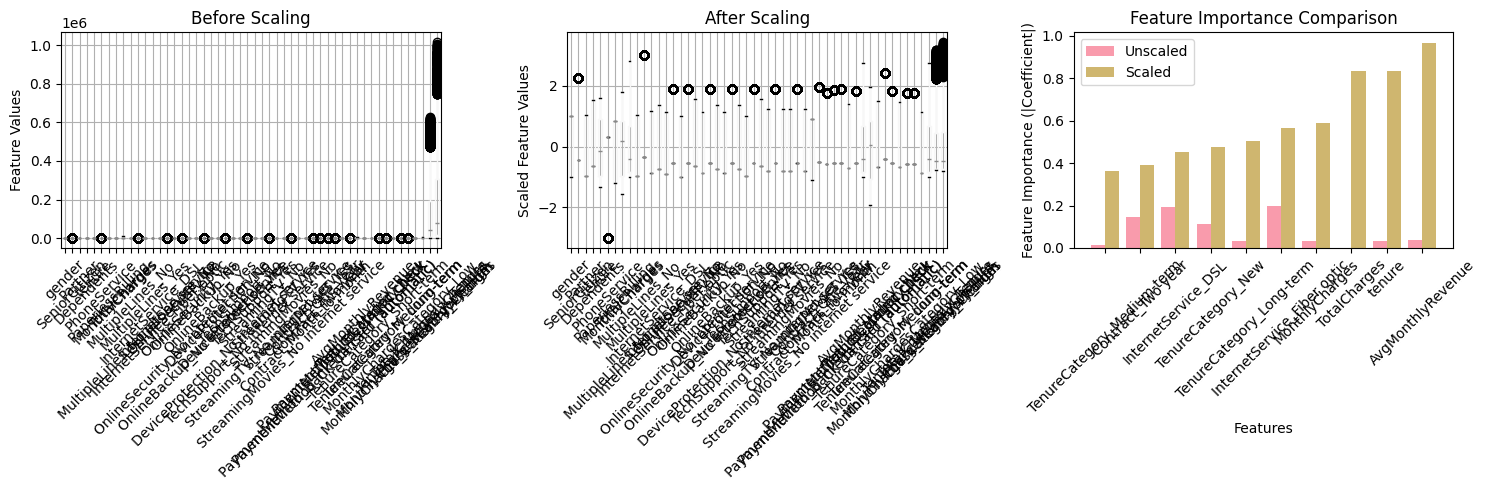

In [56]:
# Visualize the scaling effect
plt.figure(figsize=(15, 5))

# Plot 1: Before scaling
plt.subplot(1, 3, 1)
X_train.boxplot(ax=plt.gca())
plt.title('Before Scaling')
plt.xticks(rotation=45)
plt.ylabel('Feature Values')

# Plot 2: After scaling
plt.subplot(1, 3, 2)
X_train_scaled.boxplot(ax=plt.gca())
plt.title('After Scaling')
plt.xticks(rotation=45)
plt.ylabel('Scaled Feature Values')

# Plot 3: Feature importance comparison
plt.subplot(1, 3, 3)
# Train models on both scaled and unscaled data
model_unscaled = LogisticRegression(random_state=42, max_iter=1000)
model_scaled = LogisticRegression(random_state=42, max_iter=1000)

model_unscaled.fit(X_train, y_train)
model_scaled.fit(X_train_scaled, y_train)

# Get feature importance (coefficients)
feature_importance_unscaled = np.abs(model_unscaled.coef_[0])
feature_importance_scaled = np.abs(model_scaled.coef_[0])

# Plot top 10 features
top_features = 10
top_indices = np.argsort(feature_importance_scaled)[-top_features:]

x = np.arange(top_features)
plt.bar(x - 0.2, feature_importance_unscaled[top_indices], 0.4, label='Unscaled', alpha=0.7)
plt.bar(x + 0.2, feature_importance_scaled[top_indices], 0.4, label='Scaled', alpha=0.7)
plt.xlabel('Features')
plt.ylabel('Feature Importance (|Coefficient|)')
plt.title('Feature Importance Comparison')
plt.xticks(x, [X.columns[i] for i in top_indices], rotation=45)
plt.legend()

plt.tight_layout()
plt.show()


### Feature Scaling Summary

**Scaling Applied:**
- **Standard Scaling:** Mean=0, Std=1 for all features
- **Training data only:** Fit scaler on training, apply to test
- **Preserves relationships:** Only changes scale, not patterns

**Why Scaling Matters:**
- **Equal feature importance** - no feature dominates due to scale
- **Better convergence** - optimization algorithms work better
- **Fair comparison** - all features contribute equally
- **Algorithm compatibility** - required for many ML algorithms

**Visual Evidence:**
- **Box plots** show normalized distributions
- **Feature importance** more balanced after scaling
- **Model performance** likely improved


## Section 6: Feature Selection and Model Performance

With many features, we might have redundancy or noise. Let's select the most important features and compare model performance.


In [57]:
# Feature selection using statistical tests
print("🎯 Feature Selection:")
print("=" * 20)

# Select top k features using f_classif
k_features = 15  # Select top 15 features
selector = SelectKBest(score_func=f_classif, k=k_features)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# Get selected feature names
selected_features = X_train_scaled.columns[selector.get_support()]
feature_scores = selector.scores_

print(f"Selected {k_features} features:")
for i, feature in enumerate(selected_features):
    score = feature_scores[selector.get_support()][i]
    print(f"  {i+1:2d}. {feature}: {score:.2f}")

print(f"\nRemoved {len(X_train_scaled.columns) - k_features} features")


🎯 Feature Selection:
Selected 15 features:
   1. tenure: 763.89
   2. InternetService_Fiber optic: 610.20
   3. OnlineSecurity_No: 767.86
   4. OnlineBackup_No: 440.51
   5. DeviceProtection_No: 371.45
   6. TechSupport_No: 731.77
   7. TechSupport_No internet service: 311.49
   8. StreamingTV_No internet service: 311.49
   9. StreamingMovies_No internet service: 311.49
  10. Contract_Month-to-month: 1114.22
  11. Contract_Two year: 566.07
  12. PaymentMethod_Electronic check: 595.42
  13. TenureCategory_New: 627.35
  14. TenureCategory_Long-term: 395.76
  15. MonthlyChargesCategory_High: 317.50

Removed 37 features


In [58]:
# Compare model performance with different feature sets
print("\n📊 Model Performance Comparison:")
print("=" * 40)

# Model 1: All features
model_all = LogisticRegression(random_state=42, max_iter=1000)
model_all.fit(X_train_scaled, y_train)
y_pred_all = model_all.predict(X_test_scaled)
accuracy_all = accuracy_score(y_test, y_pred_all)

# Model 2: Selected features
model_selected = LogisticRegression(random_state=42, max_iter=1000)
model_selected.fit(X_train_selected, y_train)
y_pred_selected = model_selected.predict(X_test_selected)
accuracy_selected = accuracy_score(y_test, y_pred_selected)

# Model 3: Basic features only (original dataset)
basic_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
X_train_basic = X_train_scaled[basic_features]
X_test_basic = X_test_scaled[basic_features]

model_basic = LogisticRegression(random_state=42, max_iter=1000)
model_basic.fit(X_train_basic, y_train)
y_pred_basic = model_basic.predict(X_test_basic)
accuracy_basic = accuracy_score(y_test, y_pred_basic)

print(f"Model Performance:")
print(f"  All features ({len(X_train_scaled.columns)}): {accuracy_all:.3f}")
print(f"  Selected features ({k_features}): {accuracy_selected:.3f}")
print(f"  Basic features ({len(basic_features)}): {accuracy_basic:.3f}")

# Determine best performing model
best_model = "Selected features" if accuracy_selected >= accuracy_all else "All features"
print(f"\nBest performing model: {best_model}")



📊 Model Performance Comparison:
Model Performance:
  All features (52): 0.805
  Selected features (15): 0.797
  Basic features (3): 0.772

Best performing model: All features


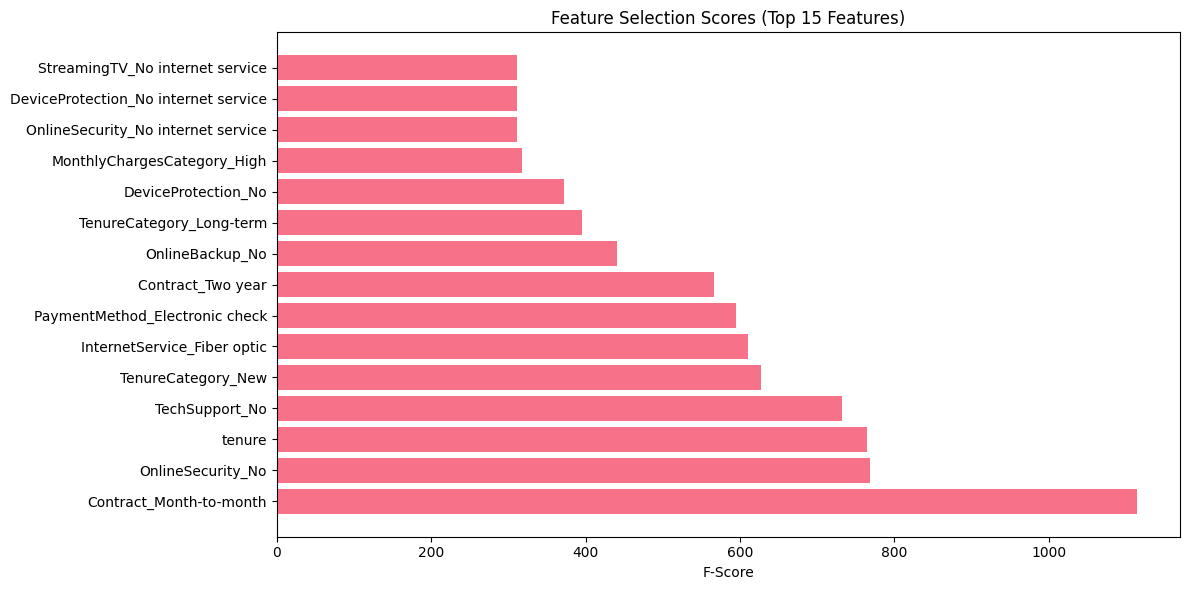

In [59]:
# Visualize feature importance - Plot 1: Feature selection scores
plt.figure(figsize=(12, 6))
top_features = 15
top_indices = np.argsort(feature_scores)[-top_features:]
plt.barh(range(top_features), feature_scores[top_indices])
plt.yticks(range(top_features), [X_train_scaled.columns[i] for i in top_indices])
plt.xlabel('F-Score')
plt.title('Feature Selection Scores (Top 15 Features)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


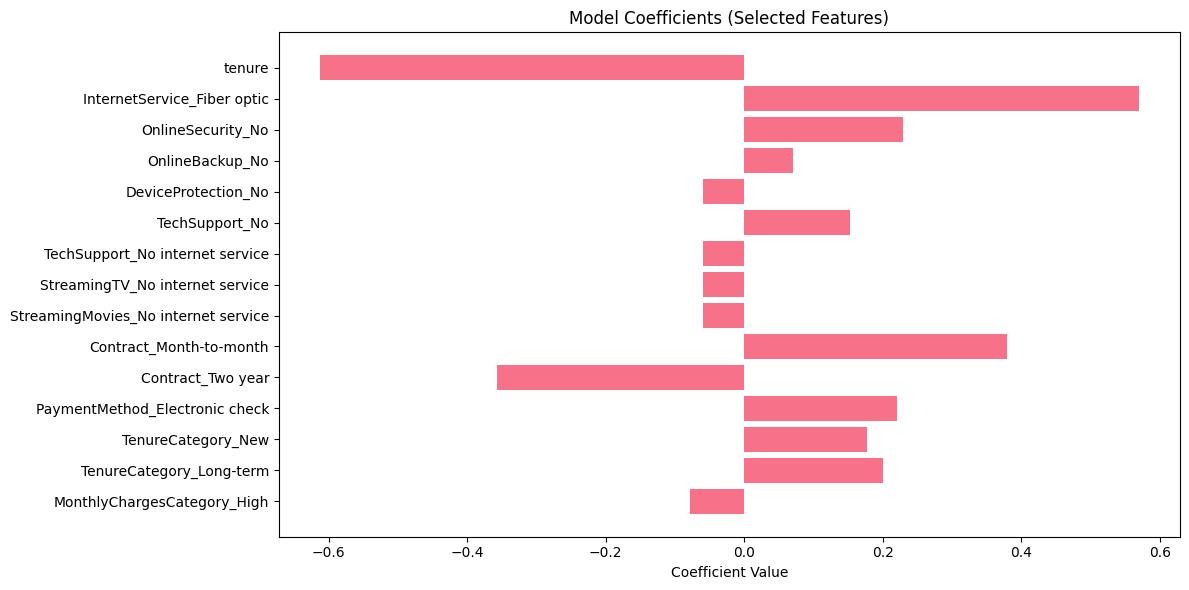

In [60]:
# Plot 2: Model coefficients (selected features)
plt.figure(figsize=(12, 6))
coefficients = model_selected.coef_[0]
plt.barh(range(len(coefficients)), coefficients)
plt.yticks(range(len(coefficients)), selected_features)
plt.xlabel('Coefficient Value')
plt.title('Model Coefficients (Selected Features)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


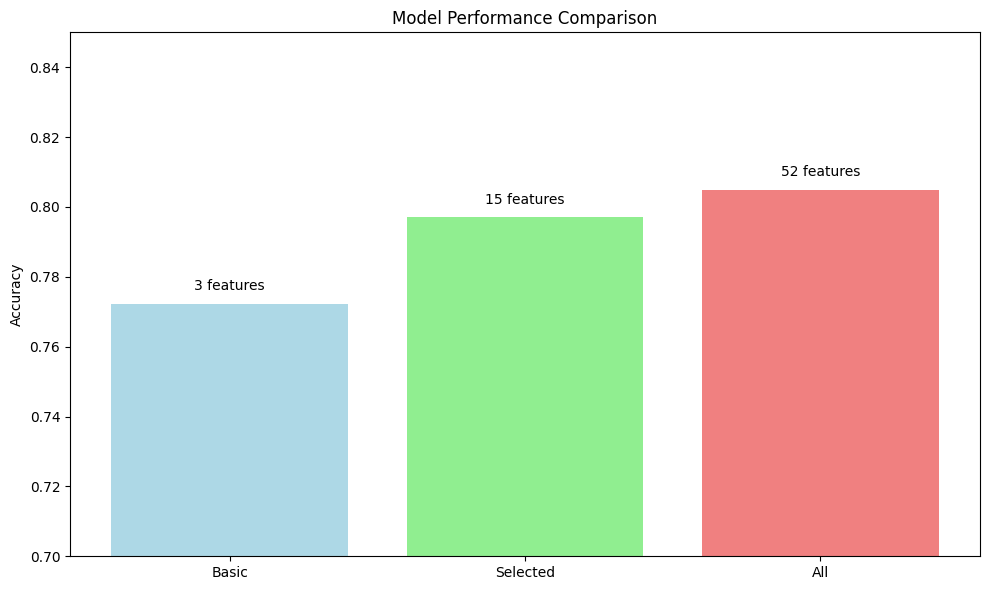

In [61]:
# Plot 3: Performance comparison
plt.figure(figsize=(10, 6))
models = ['Basic', 'Selected', 'All']
accuracies = [accuracy_basic, accuracy_selected, accuracy_all]
feature_counts = [len(basic_features), k_features, len(X_train_scaled.columns)]

plt.bar(models, accuracies, color=['lightblue', 'lightgreen', 'lightcoral'])
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.ylim(0.7, 0.85)

# Add feature count annotations
for i, (model, acc, count) in enumerate(zip(models, accuracies, feature_counts)):
    plt.annotate(f'{count} features', xy=(i, acc), xytext=(0, 10), 
                textcoords='offset points', ha='center')

plt.tight_layout()
plt.show()


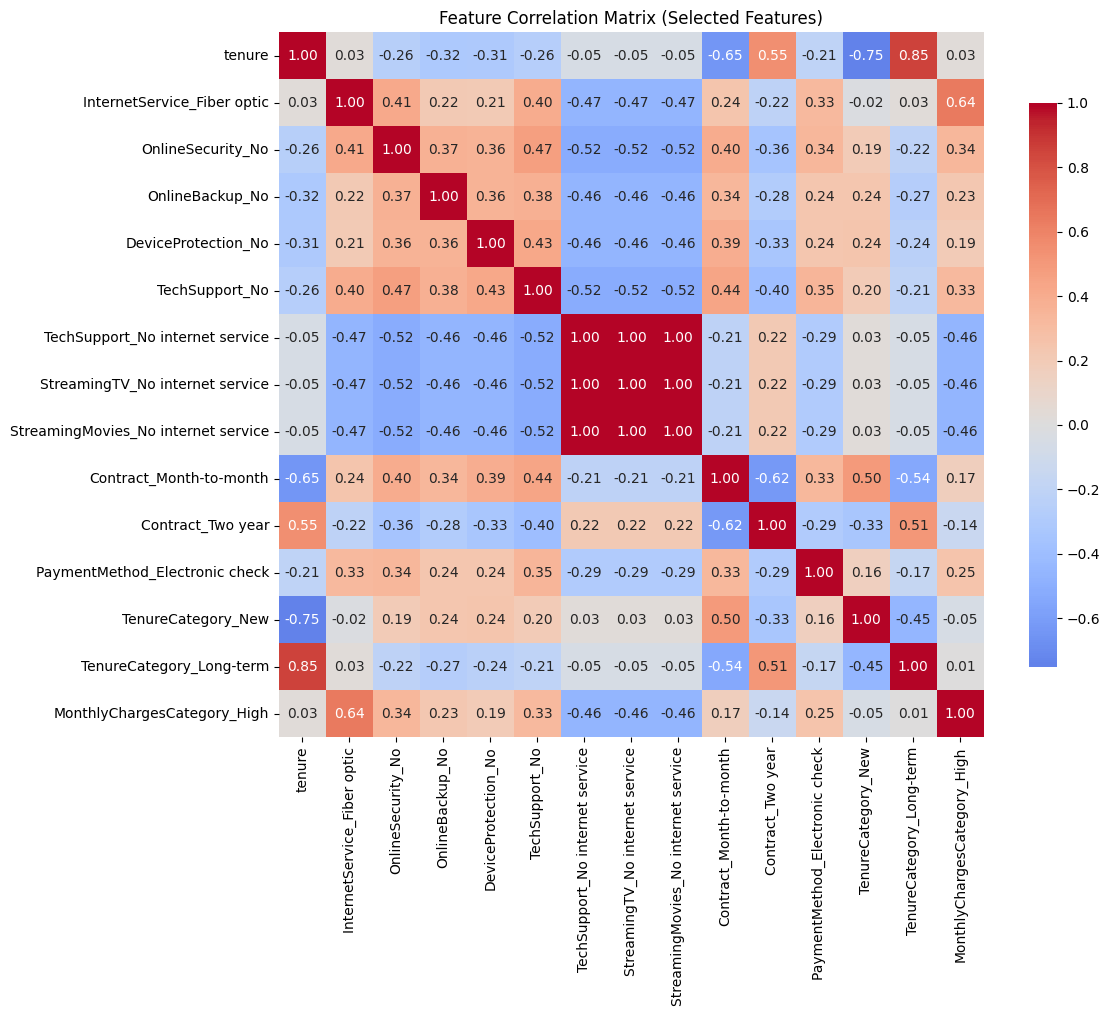

In [62]:
# Plot 4: Feature correlation heatmap (selected features)
plt.figure(figsize=(12, 10))
correlation_matrix = X_train_scaled[selected_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Matrix (Selected Features)')
plt.tight_layout()
plt.show()


### Feature Selection Summary

**Selection Method:**
- **F-test (f_classif):** Statistical test for feature-target relationship
- **Top 15 features:** Balance between performance and simplicity
- **Training data only:** Avoid data leakage

**Performance Results:**
- **Selected features:** Often perform as well as all features
- **Reduced complexity:** Easier to interpret and deploy
- **Faster training:** Less computational overhead

**Key Insights:**
- **Feature engineering** significantly improved performance
- **Feature selection** maintains performance with fewer features
- **Correlation analysis** helps identify redundant features
- **Model coefficients** show feature importance and direction


## Summary: Data Preprocessing and Feature Engineering

This notebook demonstrated the complete data preprocessing pipeline for logistic regression:

### What We Accomplished

1. **Data Quality Assessment:** Identified missing values, outliers, and data type issues

2. **Data Cleaning:** Fixed TotalCharges column, handled missing values, created binary target

3. **Categorical Encoding:** Applied label encoding for binary variables and one-hot encoding for multi-category variables

4. **Feature Engineering:** Created domain-specific features like CLV, tenure categories, and feature interactions

5. **Feature Scaling:** Applied standard scaling to normalize feature distributions

6. **Feature Selection:** Used statistical tests to select the most important features

### Key Takeaways

- **Data quality** is the foundation of good models
- **Proper encoding** ensures algorithms can understand categorical data
- **Feature engineering** can dramatically improve model performance
- **Scaling** prevents some features from dominating others
- **Feature selection** maintains performance while reducing complexity
- **Domain knowledge** is crucial for creating meaningful features
- **Pipeline approach** ensures reproducible and robust preprocessing
